### Title: 
# XGBOOST TUNED

### Description:

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.

The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem.

We will perform optimization only in the best model: XGBoost.

In this notebook, we will perform the XGBoost algorithm from the xgboost package, plot the confussion matrix and the ROC-AUC curve, Precission-Recall curve, cumulative gains curve and lift curve.

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
11/12/2020

### Version:
2.0

***

### Libraries

In [1]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

    # Impot XGBoost
import xgboost as xgb
from xgboost import plot_importance

    # Import Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import itertools
import scikitplot as skplt
    
    # Import graphviz
from graphviz import Digraph

    # Visualize DF
from IPython.display import display, HTML

    #Import pickle
import pickle

    #Import shap
import shap

## Functions

In [2]:
'''
This function prints and plots the confusion matrix:

cm = confussion_matrix using the prediction values
classes = name of the labels
cmap & tittle color map and tittle of the plot
'''
def plot_confusion_matrix(model_predictions, model_name, normalize=False): 
    cm = confusion_matrix(y_val, model_predictions, labels=[0, 1])
    classes=['Fully Pay', 'Non-payment']
    cmap = plt.cm.Reds
    title = f'{model_name} Confusion Matrix'
    fontsize = 12
    fontsize_lab = 15
    fontsize_tit = 20
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        
        # Plot params
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = fontsize_tit)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)
    
        # Itercool params
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize_lab)
    plt.xlabel('Predicted label', fontsize=fontsize_lab)

### Load data

In [3]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'X_train'

X_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory=False)                       # To avoid warnings we use set low_memory = False

name = 'Y_train'

y_train = pd.read_csv(f'../data/03_processed/{name}.csv',  # Path root: here we include an f-string with the variable name
                   low_memory=False)                       # To avoid warnings we use set low_memory = False

name = 'X_val'

X_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory=False)                       # To avoid warnings we use set low_memory = False

name = 'Y_val'

y_val = pd.read_csv(f'../data/03_processed/{name}.csv',    # Path root: here we include an f-string with the variable name
                   low_memory=False)                       # To avoid warnings we use set low_memory = False

In [4]:
    # Transform to 1d array
y_train = np.ravel(y_train)

## XGBoost Prediction

In [5]:
%%time

    # Parametrize
xgbreg = xgb.XGBClassifier()

params = {
    'n_estimators':[100, 1000],
    'reg_lambda':[0, 1],
    'gamma':[0, 1],
    'eta':[0.1, 0.3],
    'random_state':[1322], 
    'objective':['binary:logistic'],
    'n_jobs':[-3]
}

k = 5

    # GridSearchCV
grid_xgboost = GridSearchCV(estimator=xgbreg,
                            param_grid=params,
                            scoring='roc_auc',
                            cv=k,
                            verbose=1,
                            n_jobs=-3)

grid_xgboost.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed: 86.6min
[Parallel(n_jobs=-3)]: Done  80 out of  80 | elapsed: 195.7min finished


Wall time: 3h 16min 6s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [6]:
    # Show the best params
grid_xgboost.best_params_

{'eta': 0.1,
 'gamma': 0,
 'n_estimators': 100,
 'n_jobs': -3,
 'objective': 'binary:logistic',
 'random_state': 1322,
 'reg_lambda': 1}

In [7]:
    # Prediction and accuracy
y_pred = grid_xgboost.predict(X_val)
print('Accuracy of XGBoost classifier on test set: {:.5f}'.format(grid_xgboost.score(X_val, y_val)))

Accuracy of XGBoost classifier on test set: 0.73430


### Confussion Matrix

It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values.

It is extremely useful for measuring Recall, Precision, Specificity, Accuracy and most importantly AUC-ROC Curve.

#### Non normalized

Here we have the confussion matrix with the absolute values...

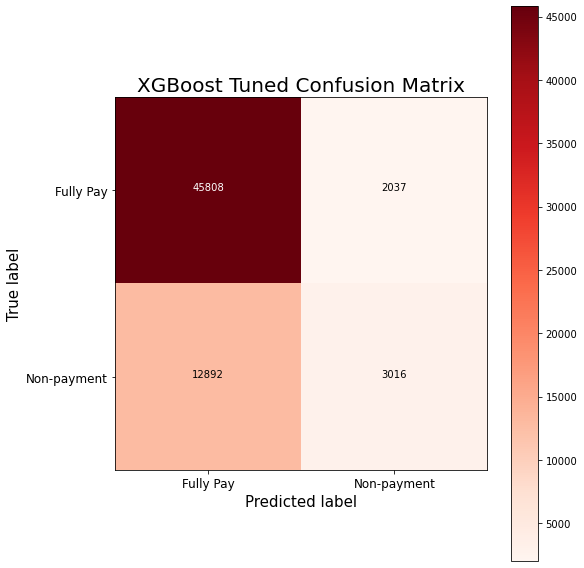

In [9]:
    # Set the size
plt.figure(figsize=(8, 8))

    # Use the function defined above
plot_confusion_matrix(y_pred, 'XGBoost Tuned', normalize=False)
plt.show()

#### Normalized

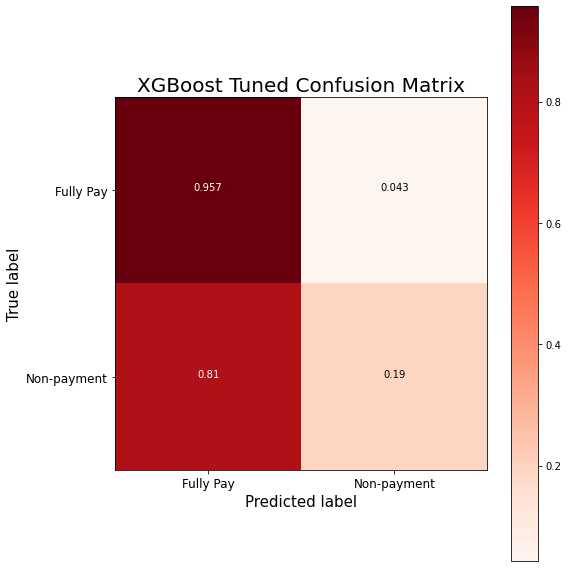

In [10]:
    # Set the size
plt.figure(figsize=(8, 8))

    # Use the function defined above
plot_confusion_matrix(y_pred, 'XGBoost Tuned', normalize=True)
plt.show()

Here we can see that our XGBoost tuned is quite good predicting Fully Pay members as the other models, because we have more than a 95% of True Positives, but is not quite good predicting Non-payment clients, this is due from the total customers that non-pay we are predicting well less than 20%.

### Classsification Report

In [11]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86     47845
           1       0.60      0.19      0.29     15908

    accuracy                           0.77     63753
   macro avg       0.69      0.57      0.57     63753
weighted avg       0.73      0.77      0.72     63753



We can see at the `classification_report` that our model predict very well Fully Pay customers, because we have a high precision (remember *Precision = TP/(TP + FP)*) and therefore our recall (*Recall = TP/(TP+FN)*) is almost 100% this makes that the f1-score (*F1 Score = 2(Recall · Precision) / (Recall + Precision)*) is 86%.

On the other hand, as we said above the XGBoost model is very poor predicting Non-payment clientes but better than the other models. The main issue is that the recall is very low, that means we can not detect all the Non-payment, in other words, we have a bigger amount of False Positives.

## ROC Curve

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

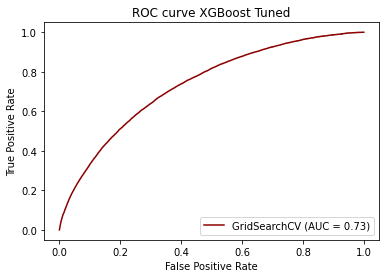

In [13]:
    # Parametrize
classifier = grid_xgboost

disp = metrics.plot_roc_curve(grid_xgboost, X_val, y_val, color='#8B0000')

# Set title
disp.ax_.set_title('ROC curve XGBoost Tuned');

In this case we have an AUC = 0.73 which is quite good.

### Precision-Recall curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

XGBoost: f1=0.288 auc=0.475


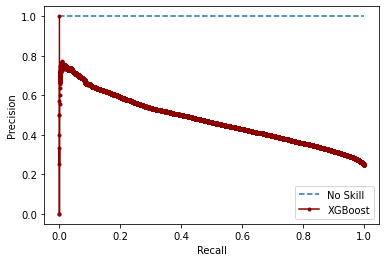

In [14]:
    # predict probabilities
lr_probs = grid_xgboost.predict_proba(X_val)
    
    # keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

    # calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_val, lr_probs)
    
    # calculate scores
lr_f1, lr_auc = f1_score(y_val, y_pred), auc(lr_recall, lr_precision)
    
    # summarize scores
print('XGBoost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
   
    # plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='XGBoost', color='#8B0000')
    
    # axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
plt.show()

As we can see in the plot above and the confussion matrix, the problem is that our model is very poor predicting the Non-payment clients because we have a low precission and a very low recall. Nevertheless we obtain better metrics than the previous version of the work.

### Cumulative gains curve

The cumulative gains curve is an evaluation curve that assesses the performance of the model and compares the results with the random pick. It shows the percentage of targets reached when considering a certain percentage of the population with the highest probability to be target according to the model.

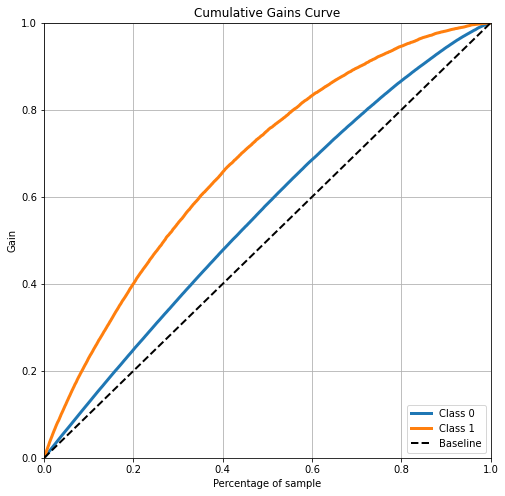

In [16]:
# Deriving Class probabilities
predicted_probabilities = grid_xgboost.predict_proba(X_val)

    # Creating the plot
skplt.metrics.plot_cumulative_gain(y_val, predicted_probabilities, figsize=(8,8));

With the xgboost tuned if we analyze the 50% of the clients we will obtain more than a 70% certainty, this is interisting if the company has to audit the clients only needs the 50% of the clients to reach the 70%.

### Lift curve

In addition to the cumulative gains curve, the lift curve is a widely used visualization of model performance. In definitive terms, the lift is a measure of the performance of a targeting model at predicting or classifying cases as having an enhanced response (for the population as a whole), measured against a random choice targeting model. Constructing a lift curve follows a similar process as forming the cumulative gain curve. Indeed, it is derived from the gain chart. First, we order observations on the horizontal axis with the highest probability of being a target on the left and vice versa for the right-hand side. On the vertical axis, the lift curve indicates how many times more than average targets are included in this group. Lift is calculated as the ratio of Cumulative Gains from classification and random models.

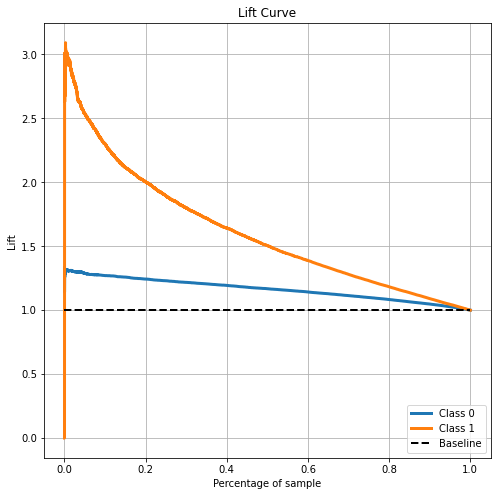

In [17]:
    # Plot the lift curve
skplt.metrics.plot_lift_curve(y_val, predicted_probabilities, figsize=(8,8));

Here we can see how many times more than average targets are included in this group. Lift is calculated as the ratio of Cumulative Gains from classification and random models. Consider the lift at 50%(the desired target of promotion); we can notice that the top 50% of observations contain 70% of targets. If the average incidence of targets is 50%, so the lift is 1.5. Thus, the model allows addressing 1.5 times more targets for this group, compared with addressing without the model, that is randomly.

In [18]:
    # Parametrize
model = grid_xgboost
filename = "xgboost_tuned.sav"

    # Save the model
pickle.dump(model, open(filename, 'wb'))

## Model Interpretability

If a machine learning model performs well, why do not we just trust the model and ignore why it made a certain decision? "The problem is that a single metric, such as classification accuracy, is an incomplete description of most real-world tasks." (Doshi-Velez and Kim 2017)

SHAP stands for SHapley Additive exPlanations³. It belongs to a class of XAI tools known as feature attribution or feature importance. These tools show the workings of Machine Learning models by uncovering how strongly different input features affect the output. The approach that SHAP uses is a solution in cooperative game theory called Shapley values (named after Lloyd Shapley, an American mathematician and Nobel laureate, who came up with the idea).

![Image](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png)

In [23]:
    # Save the model with the best params
best_model = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    eta=0.1,
    random_state=1322,
    objective='binary:logistic')

    # Train
best_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1322, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Average impact on model output magnitude

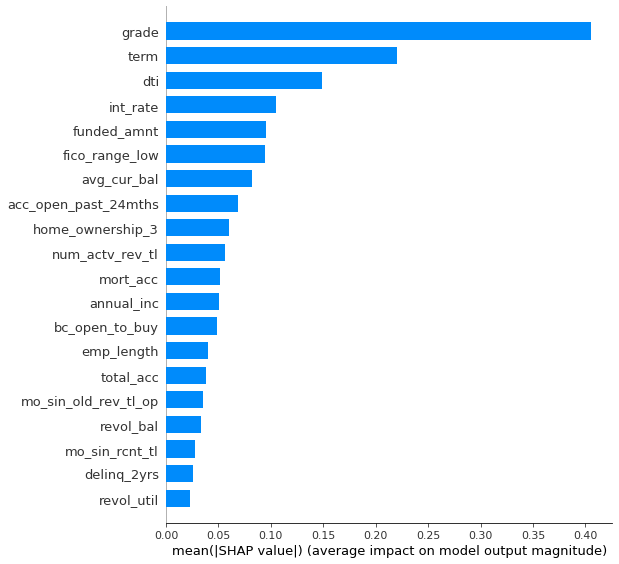

In [24]:
    # Define shap values with our model
shap_values = shap.TreeExplainer(best_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

With the XGBoost tuned the most important variable is `grade`, the importance is over 40% this sounds to high but it makes sense because this variables contains the six grades inside, also we could have an idea of the reliability. Furthermore, other important variables are `term`, `int_rate` and `funded_amnt` those varriables explain the characteristics of the loan, and are highly correlated with type of client.

### Beeswarm summary plot

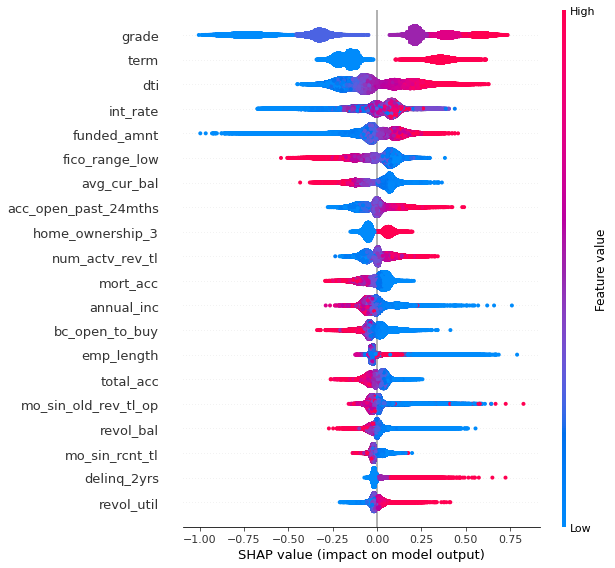

In [25]:
shap.summary_plot(shap_values, X_train)

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature fow. In our plot, we can visualize which variables explains positive and negative in our results. For example, `grade` and `funded_amnt` have more negative impact than positive. On the other hand, variables like `annual_inc` and `emp_lenght` have more positive impact than negative.

### Dependence scatter plot

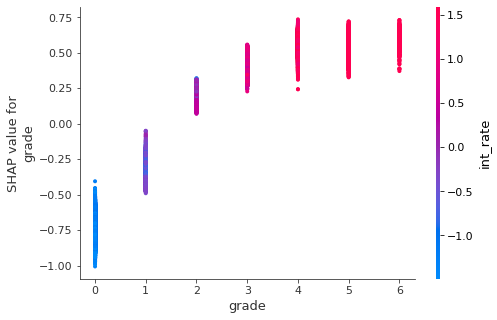

In [38]:
shap.dependence_plot('grade', shap_values, X_train)

Here we can see the dependence between `grade` and `int_rate`.The lower grade (F) we have the the more interest you pay for the loan.

### Waterfall plots

Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

In [43]:
    # Generate the explainer
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

100%|===================| 267751/267759 [14:34<00:00]        

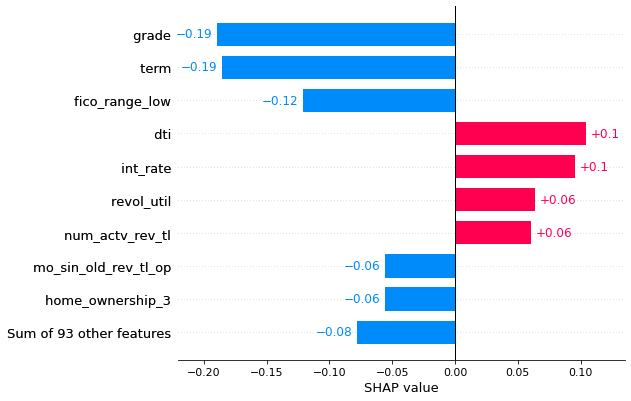

In [44]:
shap.plots.bar(shap_values[0])

Here we can see how the variables explain the decission for the customer 0, in this case grade, term and fico_range have negative impact, so probably will be denied the loan. An alternative way to visualize this is...

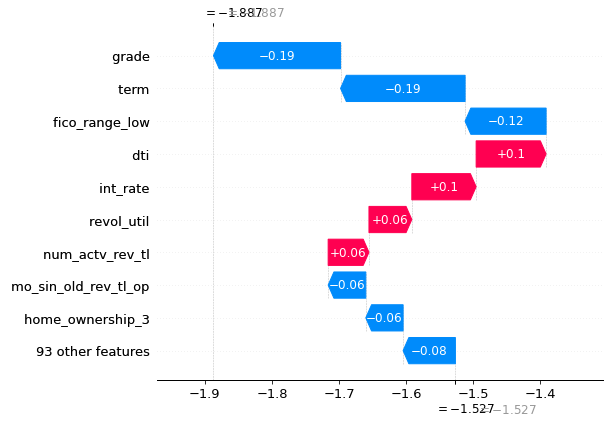

In [45]:
shap.plots.waterfall(shap_values[0])

Here we can see the same information as above.

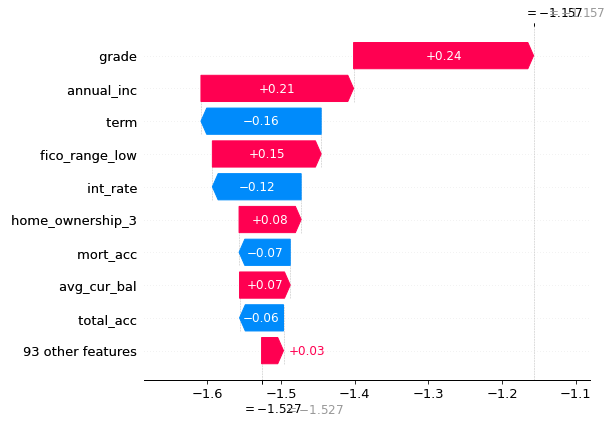

In [46]:
shap.plots.waterfall(shap_values[100])

This is another client example, here we can see that our client has a very good grade which has an impact of 24 points in addition to his annual income that has a 21 positive impact.

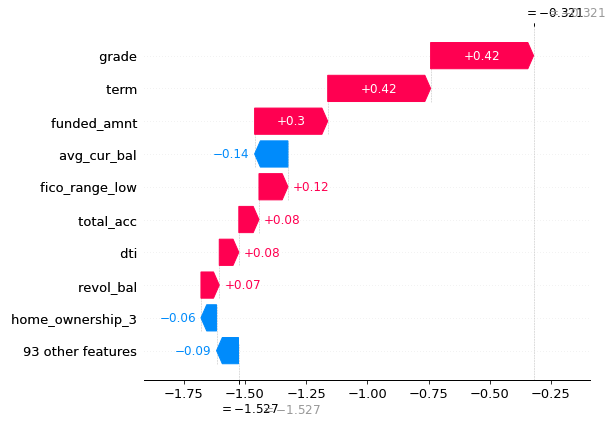

In [47]:
shap.plots.waterfall(shap_values[1000])

This is another example, this is the best of the 3 clients we showed.